In [1]:
import os
from alpha_vantage.timeseries import TimeSeries # can only get last 100 days
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from utils import plot_column_vs_time
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

In [2]:
API_KEY = os.environ['API_KEY']

## Use a python wrapper for alpha_vantage

In [3]:
stock_name = 'TSCO'
time_interval = '60min'
ts = TimeSeries(key=API_KEY, output_format='pandas')
data, meta_data = ts.get_intraday(symbol=stock_name,interval=time_interval, outputsize='full')

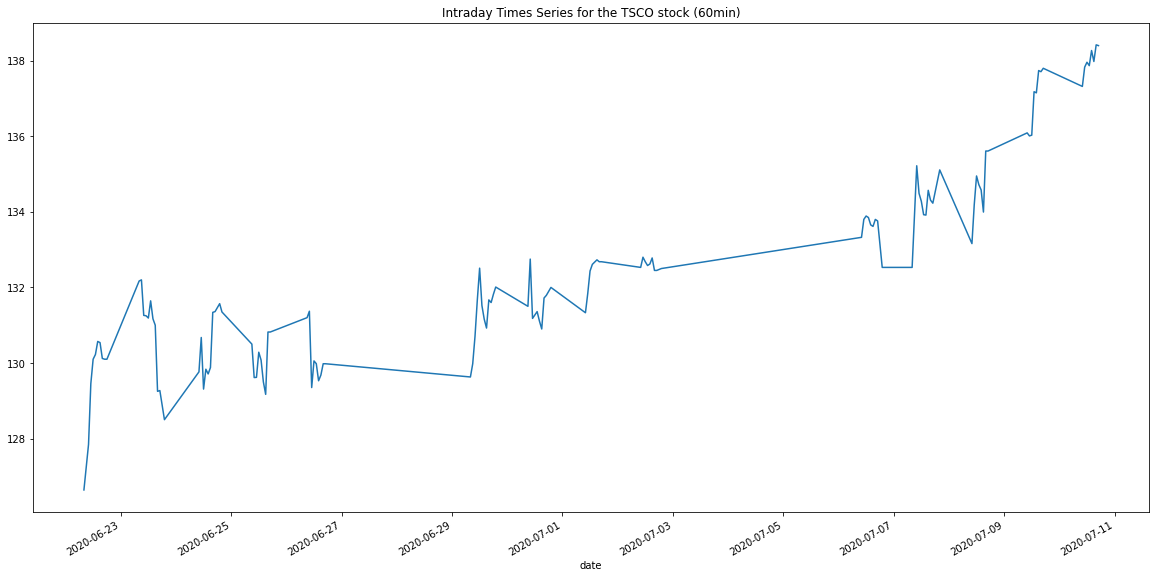

In [4]:
data['4. close'].plot()
plt.title(f'Intraday Times Series for the {stock_name} stock ({time_interval})')
plt.show()

## Sample plot for 5 chosen stocks

In [5]:
sp_500_by_cap = pd.read_csv("stock_tables/sp500_by_cap.csv")
symbols = list(sp_500_by_cap["Symbol"][:5])

In [6]:
dfs = []
for symbol in symbols:
    df = pd.read_csv(f"stock_tables/sp500_stocks/{symbol}.csv",index_col=0) # specify 0th col is index
    dfs.append(df)

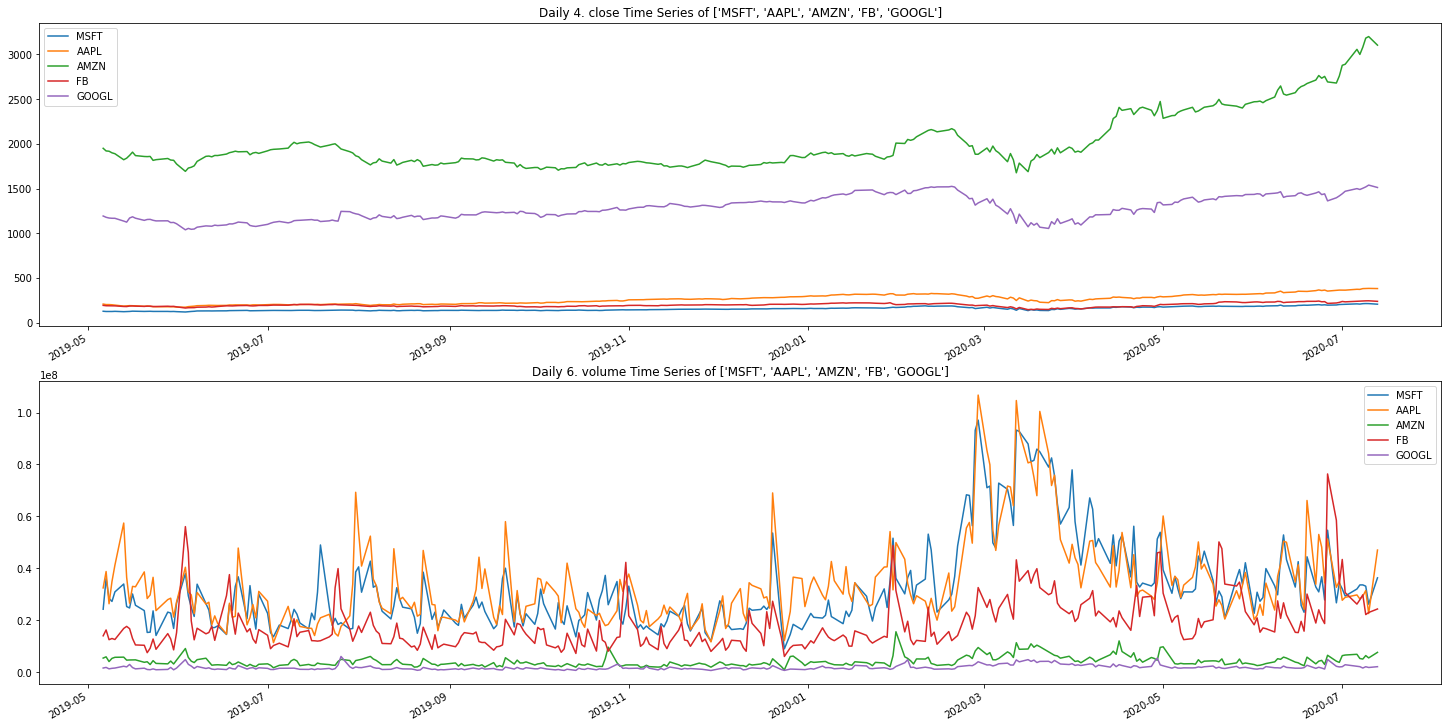

In [7]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
# plot closing prices for Tesco and Costco
plot_title1 = plot_column_vs_time('4. close',dfs, symbols, ax1)
ax1.set_title(label=plot_title1)


# plot trading volumes for Tesco and Costco
plot_title2 = plot_column_vs_time('6. volume',dfs, symbols, ax2)
ax2.set_title(label=plot_title2)

fig.tight_layout(pad=0.3)